In [1]:
from __future__ import print_function # for python 2.7 users

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D

Using TensorFlow backend.


In [4]:
from keras.applications import vgg16

In [5]:
trueVGG = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None)

In [6]:
from keras import backend as K
K.set_image_data_format( 'channels_last' ) # WARNING : important for images and tensors dimensions ordering

## Build model architecture

In [7]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'block'+str(nb)+'_conv'+str(k)
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( AveragePooling2D((2, 2), strides=(2, 2)) ) # WARNING : MaxPooling2D in **true** VGG model
    
    return L

In [8]:
def vgg_headless(): # we remove the top classification layers
    
    mdl = Sequential()
        
    # First layer is a dummy-permutation = Identity to specify input shape
    mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

    for l in convblock(64, 1, bits=2):
        mdl.add(l)

    for l in convblock(128, 2, bits=2):
        mdl.add(l)
        
    for l in convblock(256, 3, bits=3):
        mdl.add(l)
            
    for l in convblock(512, 4, bits=3):
        mdl.add(l)
            
    for l in convblock(512, 5, bits=3):
        mdl.add(l)
        
    return mdl

In [9]:
pseudoVGG = vgg_headless()

In [11]:
pseudoNames = [lr.name for lr in pseudoVGG.layers]

for lr in trueVGG.layers:
    if ('_conv' in lr.name):
        idx = pseudoNames.index(lr.name)
        print(lr.name, idx)
        Ws, Bs = lr.get_weights()
        pseudoVGG.layers[idx].set_weights([Ws, Bs])

block1_conv1 1
block1_conv2 2
block2_conv1 4
block2_conv2 5
block3_conv1 7
block3_conv2 8
block3_conv3 9
block4_conv1 11
block4_conv2 12
block4_conv3 13
block5_conv1 15
block5_conv2 16
block5_conv3 17


In [12]:
pseudoVGG.summary() # visual inspection of model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 128)       0         
__________

In [27]:
featureLayerIndex = 5
featureModel = Model(inputs=pseudoVGG.layers[0].input, outputs=pseudoVGG.layers[featureLayerIndex].output)

In [23]:
im = Image.open('ak.png') # WARNING : this image is well centered and square
im = im.resize((224,224))

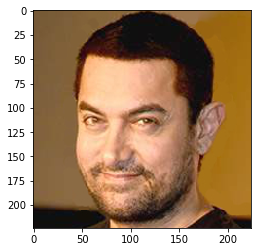

In [24]:
plt.imshow(np.asarray(im))

In [25]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)

    return kmodel.predict(imarr)

In [26]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit

pred(featureModel, crpim, transform=False).shape

(1, 112, 112, 128)

### See documentation at :
- https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
- https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

In [29]:
# build the VGG16 network
model = vgg16.VGG16(include_top=False, weights='imagenet')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [34]:
from keras import backend as K

layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

input_img = model.layers[0].input # WARNING : not sure about this line

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [37]:
import numpy as np

img_width = 128
img_height = 128

# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

ValueError: Cannot feed value of shape (1, 3, 128, 128) for Tensor u'input_2:0', which has shape '(?, ?, ?, 3)'